In [1]:
from scipy.io import wavfile
import numpy as np
import os
import glob
import time
import write_op as wo
from data_set_params import DataSetParams
#import sys
import tensorflow as tf
#from tensorflow.keras import models, layers, regularizers
from helper_fns import *
#import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
def read_audio(file_name, do_time_expansion, chunk_size, win_size):

    # try to read in audio file
    try:
        samp_rate_orig, audio = wavfile.read(file_name)
    except:
        print('  Error reading file')
        return True, None, None, None, None

    # convert to mono if stereo
    if len(audio.shape) == 2:
        print('  Warning: stereo file. Just taking right channel.')
        audio = audio[:, 1]
    file_dur = audio.shape[0] / float(samp_rate_orig)
    print('  dur', round(file_dur,3), '(secs) , fs', samp_rate_orig)

    # original model is trained on time expanded data
    samp_rate = samp_rate_orig
    if do_time_expansion:
        samp_rate = int(samp_rate_orig/10.0)
        file_dur *= 10

    # pad with zeros so we can go right to the end
    multiplier = np.ceil(file_dur/float(chunk_size-win_size))
    diff       = multiplier*(chunk_size-win_size) - file_dur + win_size
    audio_pad  = np.hstack((audio, np.zeros(int(diff*samp_rate))))
    #audio_pad = audio
    return False, audio_pad, file_dur, samp_rate, samp_rate_orig


def run_detector(det, audio, file_dur, samp_rate, detection_thresh, params):

    det_time = []
    det_prob = []

    # files can be long so we split each up into separate (overlapping) chunks
    st_positions = np.arange(0, file_dur, params.chunk_size-params.window_size)
    #print('st_positions',st_positions)
    for chunk_id, st_position in enumerate(st_positions):

        # take a chunk of the audio
        # should already be zero padded at the end so its the correct size
        st_pos      = int(st_position*samp_rate)
        en_pos      = int(st_pos + params.chunk_size*samp_rate)
        audio_chunk = audio[st_pos:en_pos]
        
        # make predictions
        chunk_spec  = compute_features(audio_chunk, samp_rate, params)
        chunk_spec  = np.squeeze(chunk_spec)
        chunk_spec  = np.expand_dims(chunk_spec,-1)
        
        det_pred    = det.predict(chunk_spec)
        
        if params.smooth_op_prediction:
            det_pred = gaussian_filter1d(det_pred, params.smooth_op_prediction_sigma, axis=0)
        
        pos, prob = nms_1d(det_pred[:,0], params.nms_win_size, file_dur)
        prob      = prob[:,0]
        
        # remove predictions near the end (if not last chunk) and ones that are
        # below the detection threshold
        if chunk_id == (len(st_positions)-1):
            inds = (prob >= detection_thresh)
        else:
            inds = np.logical_and((prob >= detection_thresh), (pos < (params.chunk_size-(params.window_size/2.0))))

        # convert detection time back into global time and save valid detections
        if pos.shape[0] > 0:
            det_time.append(pos[inds] + st_position)
            det_prob.append(prob[inds])

    if len(det_time) > 0:
        det_time = np.hstack(det_time)
        det_prob = np.hstack(det_prob)

        # undo the effects of times expansion
        if do_time_expansion:
            det_time /= 10.0

    return det_time, det_prob, pos, prob

In [28]:
# params
detection_thresh  = 0.80  # make this smaller if you want more calls detected
do_time_expansion = True  # set to True if audio is not already time expanded
save_res          = True  # save detections

params = DataSetParams()

In [29]:
# load data -
data_dir   = 'data/labelled_data/'+params.test_set+'/train/' # path of the data that we run the model on
op_ann_dir = 'results/detections/'      # where we will store the outputs
op_file_name_total = op_ann_dir + 'op_file.csv'
if not os.path.isdir(op_ann_dir):
    os.makedirs(op_ann_dir)

In [30]:
# load gpu lasagne model
model_dir  = 'results/'+params.test_set+'_big_cnn.h5'

det = tf.keras.models.load_model(model_dir)

params.chunk_size = 4.0

In [31]:
# read audio files
audio_files = glob.glob(data_dir + '*.wav')[:5]
#print(audio_files)
# loop through audio files
file_name = audio_files[0]

In [32]:
file_name_root = file_name[len(data_dir):]
print('\n', 1, 'of', len(audio_files), '\t', file_name_root)


 1 of 5 	 50689631516bcb8d0a0001ac.wav


In [33]:
# read audio file - skip file if cannot read
read_fail, audio, file_dur, samp_rate, samp_rate_orig = read_audio(file_name,
                        do_time_expansion, params.chunk_size, params.window_size)

  dur 3.84 (secs) , fs 44100


In [34]:
# run detector
import time
tic = time.time()
det_time, det_prob, full_time, full_prob = run_detector(det, audio, file_dur, samp_rate, detection_thresh, params)
toc = time.time()

print('  detection time', round(toc-tic, 3), '(secs)')
num_calls = len(det_time)
print('  ' + str(num_calls) + ' calls found')

  detection time 3.984 (secs)
  41 calls found


In [35]:
import matplotlib.pyplot as plt

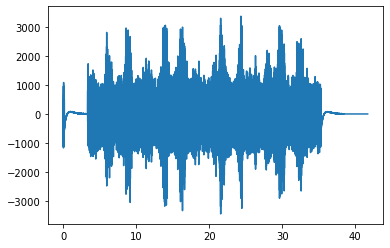

In [36]:
#plt.scatter(det_time, det_prob)
xs_time = np.linspace(0, len(audio) / samp_rate, num=len(audio))
plt.plot(xs_time, audio)

In [37]:
#from helper_fns import *

In [38]:
chunk_spec  = compute_features(audio, samp_rate, params)
chunk_spec  = np.squeeze(chunk_spec)
chunk_spec  = np.expand_dims(chunk_spec,-1)

det_pred    = det.predict(chunk_spec)

if params.smooth_op_prediction:
    det_pred = gaussian_filter1d(det_pred, params.smooth_op_prediction_sigma, axis=0)

pos, prob = nms_1d(det_pred[:,0], params.nms_win_size, file_dur)

In [39]:
chunk_spec.shape

(7070, 130, 20, 1)

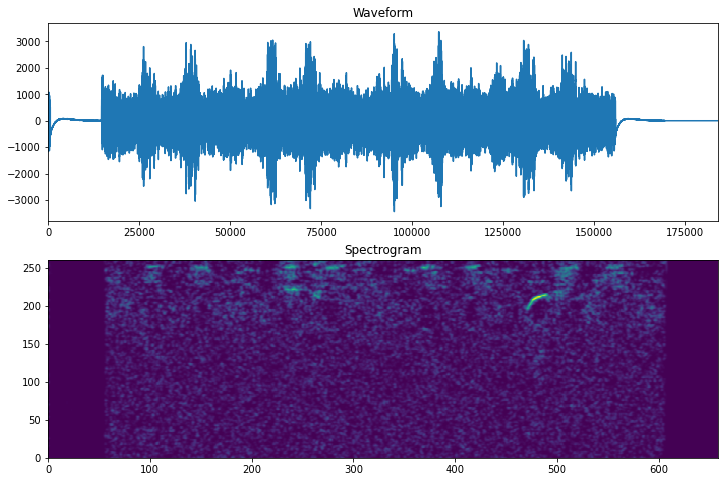

In [58]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    #log_spec = np.log(spectrogram.T)
    ax.pcolormesh(spectrogram)

full_spec = gen_spectrogram(audio_samples, sampling_rate, params.fft_win_length, params.fft_overlap,
                            crop_spec=params.crop_spec, max_freq=params.max_freq, min_freq=params.min_freq)
full_spec = process_spectrogram(full_spec, denoise_spec=params.denoise, mean_log_mag=params.mean_log_mag, 
                                smooth_spec=params.smooth_spec)
    

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(audio.shape[0])
axes[0].plot(timescale, audio)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, audio.shape[0]])
plot_spectrogram(full_spec, axes[1])
axes[1].set_title('Spectrogram')
plt.show()

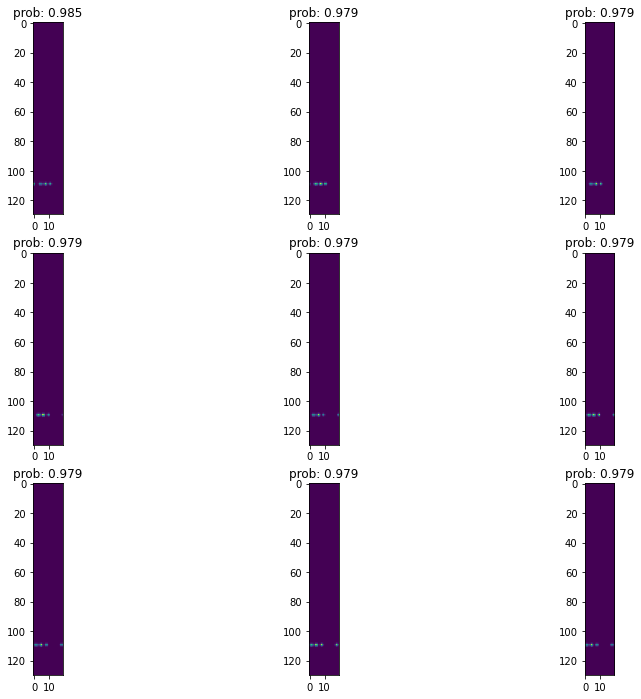

In [40]:
#example visualisations of audio files
rows = 3
cols = 3
n    = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 12))
for i, spec_i in enumerate(chunk_spec[500:(500+n),:,:,:]):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.imshow(spec_i)
    #ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = 'prob: '+str(prob[i,0].round(3))
    ax.set_title(label)

plt.show()

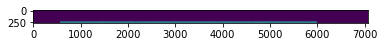

In [50]:
spec = gen_spectrogram(audio, samp_rate, params.fft_win_length, params.fft_overlap,
                       crop_spec=params.crop_spec, max_freq=params.max_freq, min_freq=params.min_freq)
#spec = process_spectrogram(spec, denoise_spec=params.denoise, mean_log_mag=params.mean_log_mag, smooth_spec=params.smooth_spec)
plt.imshow(spec)

In [42]:
sampling_rate, audio_samples = wavfile.read(data_dir+os.listdir(data_dir)[0])

In [43]:
data_dir+os.listdir(data_dir)[0]

'data/labelled_data/norfolk/train/50689631516bcb8d0a0001ac.wav'

In [44]:
file_name

'data/labelled_data/norfolk/train\\50689631516bcb8d0a0001ac.wav'

In [45]:
samp_rate_orig, sampling_rate

(44100, 44100)

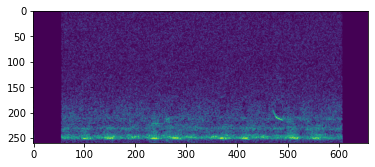

In [46]:
plt.imshow(gen_spectrogram(audio_samples, sampling_rate, params.fft_win_length, params.fft_overlap,
                crop_spec=params.crop_spec, max_freq=params.max_freq, min_freq=params.min_freq))

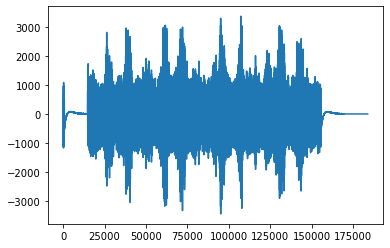

In [47]:
plt.plot(audio)

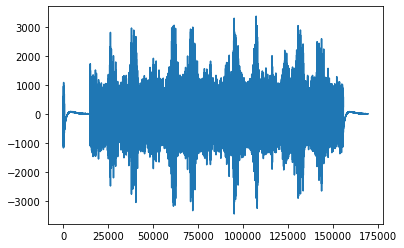

In [49]:
plt.plot(audio_samples)